In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['TfIdf'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bag_of_frames.loc[indexes_train_1].values
X_train['stack_2'] = df_bag_of_frames.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bag_of_frames.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bag_of_frames.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

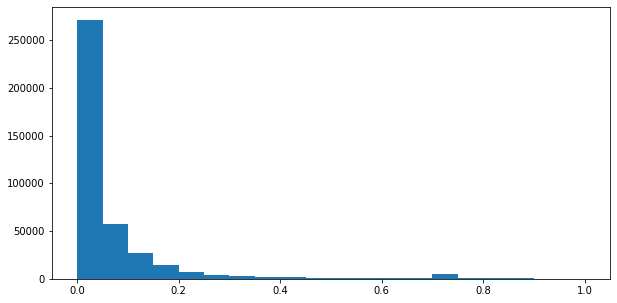

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

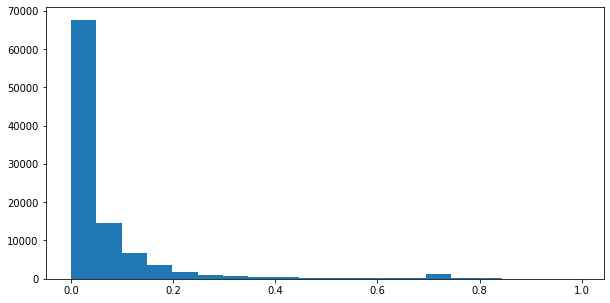

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 8

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

512

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'tanh'))
x.add(Dense(1024, activation = 'tanh'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model(shared_model, input_shape, b, m, is_sparse = True, print_summary = True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2244)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2244)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          7220736     input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_2[0][0]                

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model(model, X_train, X_validation, Y_train, Y_validation, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 29s 30ms/step - loss: 0.0055 - ham_dist_loss: 0.0055 - prod_vec_loss: 0.0117 - prod_vec_1_loss: 0.0117 - sum_vec_loss: 2.9457e-04 - sum_vec_1_loss: 2.7163e-04 - ham_dist_rmse: 0.0742 - ham_dist_mae: 0.0285 - val_loss: 0.0012 - val_ham_dist_loss: 0.0012 - val_prod_vec_loss: 0.0037 - val_prod_vec_1_loss: 0.0038 - val_sum_vec_loss: 1.5074e-04 - val_sum_vec_1_loss: 1.4716e-04 - val_ham_dist_rmse: 0.0340 - val_ham_dist_mae: 0.0157
Epoch 2/20
781/781 [==============================] - 22s 28ms/step - loss: 8.7148e-04 - ham_dist_loss: 8.3386e-04 - prod_vec_loss: 0.0027 - prod_vec_1_loss: 0.0028 - sum_vec_loss: 1.4026e-04 - sum_vec_1_loss: 1.4387e-04 - ham_dist_rmse: 0.0289 - ham_dist_mae: 0.0134 - val_loss: 8.4535e-04 - val_ham_dist_loss: 8.2348e-04 - val_prod_vec_loss: 0.0022 - val_prod_vec_1_loss: 0.0022 - val_sum_vec_loss: 1.4828e-04 - val_sum_vec_1_loss: 1.7226e-04 - val_ham_dist_rmse: 0.0287 - val_ham_dist_mae: 0.0128
Epoch 3/20
781/7

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{DeepLSH}$

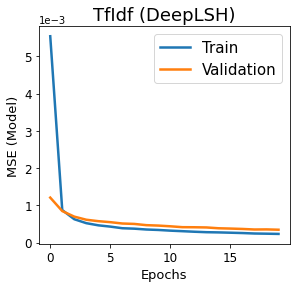

In [21]:
plt.rcParams["figure.figsize"] = (4.5,4)
plt.plot(siamese_model.history['loss'], linewidth = 2.5)
plt.plot(siamese_model.history['val_loss'], linewidth = 2.5)
plt.title('TfIdf (DeepLSH)', fontsize = 18)
plt.ylabel('MSE (Model)', fontsize = 13)
plt.xlabel('Epochs', fontsize = 13)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))
plt.savefig('Results/DeepLSH/loss-MSE.png', bbox_inches='tight')
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of LSH preserving loss

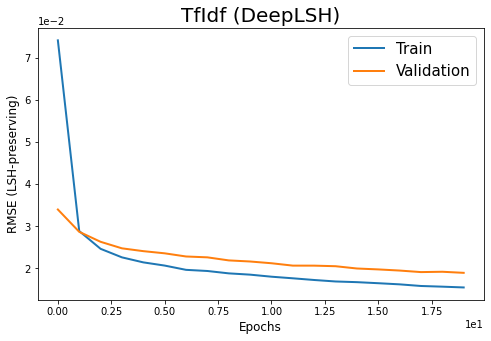

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('TfIdf (DeepLSH)', fontsize = 20)
plt.ylabel('RMSE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

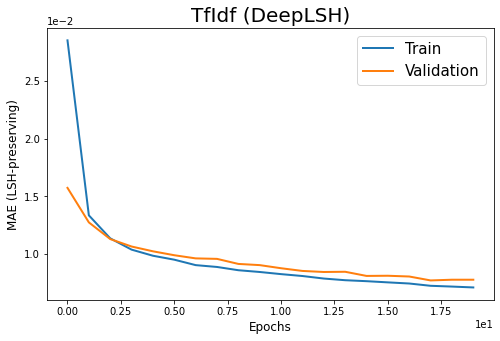

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('TfIdf (DeepLSH)', fontsize = 20)
plt.ylabel('MAE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.   , 0.   , 0.   , 0.   , 0.048, 0.   , 0.031, 0.   , 0.   ,
       0.   , 0.   , 0.168, 0.076, 0.046, 0.016, 0.   , 0.   , 0.063,
       0.125, 0.062, 0.738, 0.   , 0.032, 0.   , 0.094, 0.016, 0.248,
       0.   , 0.   , 0.   , 0.047, 0.071, 0.109, 0.386, 0.   , 0.567,
       0.   , 0.   , 0.204, 0.03 , 0.   , 0.062, 0.   , 0.   , 0.   ,
       0.366, 0.172, 0.   , 0.   , 0.031], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.   , 0.   , 0.   , 0.   , 0.049, 0.   , 0.051, 0.   , 0.   ,
       0.   , 0.   , 0.16 , 0.075, 0.049, 0.042, 0.011, 0.   , 0.073,
       0.142, 0.07 , 0.786, 0.   , 0.033, 0.   , 0.106, 0.   , 0.19 ,
       0.   , 0.   , 0.   , 0.054, 0.07 , 0.106, 0.374, 0.   , 0.583,
       0.   , 0.   , 0.206, 0.   , 0.   , 0.086, 0.   , 0.   , 0.   ,
       0.428, 0.172, 0.   , 0.   , 0.042])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

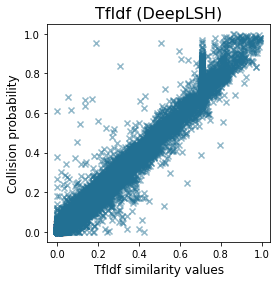

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('TfIdf (DeepLSH)', fontsize = 16)
plt.xlabel("TfIdf similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/DeepLSH/TfIdf-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.9119441132468264

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.8237733998668372

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 2
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [32]:
intermediate_model.save('Models/model-deep-lsh.model')

INFO:tensorflow:Assets written to: Models/model-deep-lsh.model/assets


In [33]:
#intermediate_model = keras.models.load_model('Models/model-deep-lsh.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [34]:
intermediate_model.predict(df_bag_of_frames.iloc[[10]])[0][:32]

array([-1.       ,  1.       , -1.       , -1.       , -1.       ,
       -1.       ,  1.       , -1.       ,  1.       ,  1.       ,
        1.       ,  1.       ,  1.       , -1.       , -1.       ,
       -1.       , -1.       ,  0.9999992,  1.       , -1.       ,
        1.       , -1.       , -1.       , -1.       , -1.       ,
       -1.       , -1.       , -1.       ,  1.       , -1.       ,
       -1.       , -1.       ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [35]:
hash_vectors = intermediate_model.predict(df_bag_of_frames)

In [36]:
np.mean(np.abs(hash_vectors))

0.99186134

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [37]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.818953125

### 3.3.4. Comparison between approximate hamming and real hamming

In [38]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

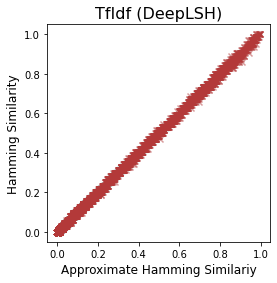

In [39]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('TfIdf (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/TfIdf-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [40]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [41]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)


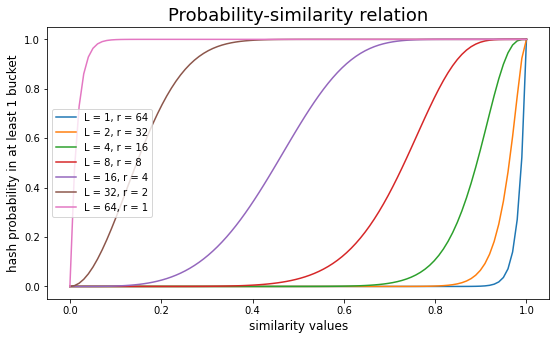

In [42]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [43]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'TfIdf', trace = False)

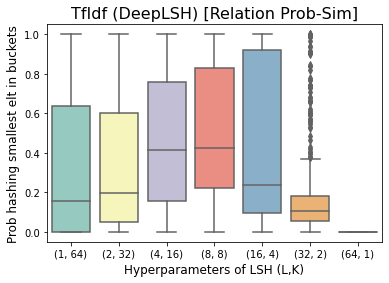

In [44]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('TfIdf (DeepLSH) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/DeepLSH/TfIdf-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [45]:
'Exemple, L = K = 8'
L, K = params[3]
L, K

(8, 8)

In [46]:
df_probLSH.mean()['(8, 8)']

0.5091929739372132

In [47]:
df_probLSH.median()['(8, 8)']

0.4249860111192594

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [48]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [49]:
with open('Hash-Tables/hash_tables_deeplsh.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [50]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

998

In [51]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{214, 285, 369, 523, 542, 573, 734, 762, 787, 817, 998}

In [52]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [53]:
near_duplicates_sim = df_measures['TfIdf'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

386448    0.865549
464518    0.865549
483027    0.865549
477132    0.865549
471532    0.865549
395302    0.865549
244957    0.812055
191778    0.805130
301363    0.782064
408973    0.769514
Name: TfIdf, dtype: float64

In [54]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'TfIdf', n_stacks, n_duplicate_pairs)
set_real_nns

{214, 285, 369, 523, 542, 573, 734, 762, 787, 817}

In [55]:
real_nns_sim[:n_duplicate_pairs]

483027    0.865549
471532    0.865549
464518    0.865549
395302    0.865549
386448    0.865549
477132    0.865549
244957    0.812055
191778    0.805130
301363    0.782064
408973    0.769514
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [56]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'TfIdf')

0.757

In [57]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[4], hash_vectors_hamming, b, df_measures, k_first_positions, 'TfIdf')

0.9510337323177367

-----------------------------------------------------------------

In [58]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'TfIdf')

0.8549999999999989

In [59]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'TfIdf')

0.8292682926829268

-----------------------------------------------------------------

In [60]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'TfIdf')

0.8801999999999989

In [61]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'TfIdf')

0.8029850746268654

In [62]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

1.0

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [63]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'TfIdf', trace = False)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    0.881095
(2, 32)    0.879498
(4, 16)    0.883924
(8, 8)     0.919665
(16, 4)    0.900016
(32, 2)    0.850972
(64, 1)    0.993805
dtype: float64

### 4.4.3. Recall w.r.t. LSH

In [64]:
df_recall = recall_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'TfIdf', trace = False)
df_recall.mean(skipna = True)

(1, 64)    0.375556
(2, 32)    0.554625
(4, 16)    0.716531
(8, 8)     0.804695
(16, 4)    0.861418
(32, 2)    0.773333
(64, 1)    0.975146
dtype: float64

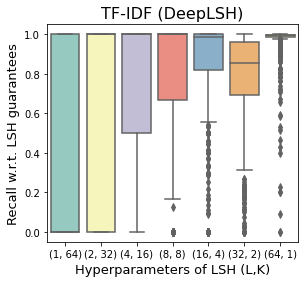

In [65]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Recall w.r.t. LSH guarantees", fontsize = 13)
plt.title('TF-IDF (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Recall-LSH', bbox_inches='tight')
plt.show()

### 4.4.4. Precision w.r.t. LSH

In [66]:
df_precision = precision_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'TfIdf', trace = False)
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.326087
(2, 32)    0.387694
(4, 16)    0.563716
(8, 8)     0.675925
(16, 4)    0.767333
(32, 2)    0.720159
(64, 1)    0.889992
dtype: float64

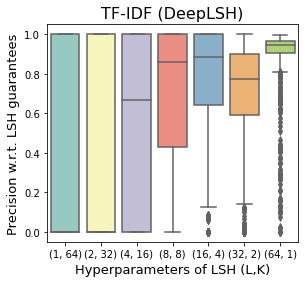

In [67]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 13)
plt.title('TF-IDF (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/precision-LSH', bbox_inches='tight')
plt.show()

### 4.4.5. Fscore w.r.t. LSH

In [68]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.216794
(2, 32)    0.313772
(4, 16)    0.507885
(8, 8)     0.636527
(16, 4)    0.768382
(32, 2)    0.711307
(64, 1)    0.920442
dtype: float64

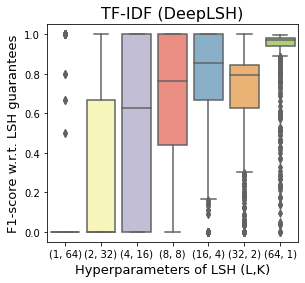

In [69]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 13)
plt.title('TF-IDF (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/fscore-LSH', bbox_inches='tight')
plt.show()